## Segment and modify an image to produce value images

In [1]:
# General imports
import torch
import random
import numpy as np
import os, sys
from datetime import datetime
import matplotlib.pyplot as plt
torch.backends.cudnn.enabled = False

In [2]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_lists, write_lists, ensure_dir, list_to_dict, read_json, load_image, informal_log, get_image_id, save_image
from utils.model_utils import prepare_device, quick_predict
from parse_config import ConfigParser
from utils.segmentation_utils import segment_modify_multi_method
from utils.visualizations import show_image_rows, make_grid
from segment import segment_modify_save
import model.model as module_arch

In [3]:
config_path = 'configs/copies/cinic10_imagenet_segmentation_edit_trials.json'
target_class = 'cat'
incorrect_images_path = os.path.join('metadata', 'CINIC10-ImageNet', target_class, 'vgg16_bn', 'incorrect_image_paths.txt')
n_select = 20

log_path = 'temp/{}_{}_edit_image/log.txt'.format(n_select, target_class)

seed = 0 # Set to None if want true randomness
debug = True

In [4]:
timestamp = datetime.now().strftime(r'%m%d_%H%M%S')

In [5]:
### Obtain incorrect images to use for edit
all_incorrect_images = np.array(read_lists(incorrect_images_path))
n_images = len(all_incorrect_images)
np.random.seed(seed)
random.seed(seed)
# key_images = all_incorrect_images[np.random.randint(n_images, size=n_select)]
# TODO: NEED TO TEST
rng = np.random.default_rng(seed)
random_idxs = rng.choice(n_images, size=n_select, replace=False)
assert len(set(random_idxs)) == len(list(random_idxs))

key_images = all_incorrect_images[random_idxs]
print(key_images)


if not debug:
    plt.ioff()


['data/cinic-10-imagenet/train/cat/n02123242_6867.png'
 'data/cinic-10-imagenet/train/cat/n02124623_8601.png'
 'data/cinic-10-imagenet/train/cat/n02128757_1805.png'
 'data/cinic-10-imagenet/train/cat/n02128925_34467.png'
 'data/cinic-10-imagenet/train/cat/n02125494_4792.png'
 'data/cinic-10-imagenet/train/cat/n02129991_724.png'
 'data/cinic-10-imagenet/train/cat/n02123394_4630.png'
 'data/cinic-10-imagenet/train/cat/n02129165_11455.png'
 'data/cinic-10-imagenet/train/cat/n02129923_3381.png'
 'data/cinic-10-imagenet/train/cat/n02125311_21228.png'
 'data/cinic-10-imagenet/train/cat/n02121808_3994.png'
 'data/cinic-10-imagenet/train/cat/n02125311_10774.png'
 'data/cinic-10-imagenet/train/cat/n02121808_843.png'
 'data/cinic-10-imagenet/train/cat/n02122298_8796.png'
 'data/cinic-10-imagenet/train/cat/n02127808_7909.png'
 'data/cinic-10-imagenet/train/cat/n02125081_2372.png'
 'data/cinic-10-imagenet/train/cat/n02129991_3446.png'
 'data/cinic-10-imagenet/train/cat/n02128757_19470.png'
 'data/

## Define variables shared across all images

In [6]:
# Obtain class list
class_list_path = os.path.join('metadata', 'cinic-10', 'class_names.txt')
class_list = read_lists(class_list_path)
class_to_idx_dict = list_to_dict(class_list)

# General save directories
save_dir_root = os.path.join('saved', 'segmentations', 'semantics', '{}_{}'.format(target_class, n_select))
path_save_dir = os.path.join('paths', 'edits', 'semantics', target_class, timestamp)
ensure_dir(path_save_dir)
# Set parameters for segmentation
felzenszwalb_params = {
    'scale': 0.9,
    'sigma': 0.25,
    'min_size': 50
}
quickshift_params = {
    'max_dist': 25,
    'kernel_size': 3,
    'sigma': 0.9,
}
slic_params = {
    'n_segments': 10,
}

watershed_params = {
    'markers': 10,
    'watershed_line': True
}

# Set segmentation methods
methods = []
methods.append(('felzenszwalb', felzenszwalb_params))
methods.append(('quickshift', quickshift_params))
methods.append(('slic', slic_params))
methods.append(('watershed', watershed_params))

In [7]:
# Load config file, and class names file
config_json = read_json(config_path)
config = ConfigParser(config_json, make_dirs=False)
class_names = read_lists(class_list_path)

# Load model and switch to eval mode
layernum = config.config['layernum']
device, _ = prepare_device(config['n_gpu'])
model = config.init_obj('arch', module_arch, layernum=layernum)
model.eval()

CIFAR10PretrainedModelEdit(
  (model): VGG(
    (normalize): InputNormalize()
    (layer0): Sequential(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (layer3): Sequential(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, moment

In [11]:
# function definition
def segment_semantically(image,
            image_id,
            methods_params,
            model,
            device,
            target_idx,
            seed=None,
            save_dir=None,
            plot_absolute=True,
            debug=False):
    
    # Create save paths
    if save_dir is not None:
        ensure_dir(save_dir)
        segmentation_save_path = os.path.join(save_dir, 'segmentations.pth')
        
    else:
        segmentation_save_path = None
        
    # Get logits/softmax of original image
    
    image_logits = quick_predict(model, image, device)
    image_softmax = torch.softmax(image_logits, dim=1)

    if save_dir is not None:
        # image_outputs_save_path = os.path.join(save_dir, 'image_outputs.pth')
        image_save_data = {
            'original_logits': image_logits,
            'original_softmax': image_softmax
        }
        
    segmentation_data = segment_modify_multi_method(
        image=image,
        methods_params=methods_params,
        seed=seed,
        save_path=segmentation_save_path)
    
    if not torch.is_tensor(image):
        image = torch.from_numpy(image).to(device)

    logit_image_save_paths = []
    softmax_image_save_paths = []
    unsuccessful_edit_save_paths = []
    mod_types = ['masked', 'gaussian']
    for seg_idx, (seg_method, _ )in enumerate(methods_params):
        for mod_type in mod_types:
            # Create one save object for logits/softmax
            save_data = { 'image_data': image_save_data }
            
            # Create save directory
            if save_dir is not None:
                local_save_dir = os.path.join(save_dir, "{}_{}".format(seg_method, mod_type))
                ensure_dir(local_save_dir)
                    
            # Obtain modified images 
            modified_images = segmentation_data['{}_modified_images'.format(mod_type)][seg_idx]
            n_images = len(modified_images)
            
            # Pass segments through model
            modified_images = np.stack(modified_images, axis=0)
            modified_images = torch.from_numpy(modified_images).to(device)
            segment_logits = quick_predict(
                model=model,
                image=modified_images,
                device=device, 
                data_format='CHW')
            segment_softmax = torch.softmax(segment_logits, dim=1)
            for out_type in ['logits', 'softmax']:
                
                if out_type == 'softmax':
                    segment_out = segment_softmax
                    image_out = image_softmax
                else: 
                    segment_out = segment_logits
                    image_out = image_logits

                # Sort output by target score
                segment_out_target_class = segment_out[:, target_idx]
                out_sorted_idx = torch.argsort(segment_out_target_class, descending=True)

                # Sort individual segments and model outputs
                sorted_segments = modified_images[out_sorted_idx]
                segment_out = segment_out[out_sorted_idx]
                
                # Prepend original image and its output score to tensors
                sorted_segments = torch.cat([torch.unsqueeze(image, dim=0), sorted_segments], dim=0)
                segment_out = torch.cat([image_out, segment_out], dim=0)
                # print(image_logits.shape, image_logits)
                # print(segment_logits.shape, segment_logits)
                # This is just for visualization purposes later
                segment_logits = torch.cat([image_logits, segment_logits], dim=0)
                # print(segment_logits.shape, segment_logits)
                
                # print(image_softmax.shape, image_softmax)
                # print(segment_softmax.shape, segment_softmax)
                segment_softmax1 = torch.cat([image_softmax, segment_softmax], dim=0)
                # print(segment_softmax.shape, segment_softmax)
                
                # Obtain predictions for individual segments
                segment_predictions = torch.argmax(segment_out, dim=1)
                print(segment_predictions)
                print(len(class_list))
                segment_prediction_strings = [class_list[pred] for pred in segment_predictions]
                # Isolate output (logits/softmax) for the target idx
                segment_target_out = segment_out[:, target_idx]
                # segment_target_out = torch.cat([image_out[:, target_idx], segment_target_out], dim=0)
                print(sorted_segments.shape, segment_target_out.shape)

                # Accumulate sorted segments
                accumulation_image = torch.clone(image)
                cumulative_images = []
                for image_segment in sorted_segments:
                    # Isolate segment and add to accumulation_image
                    segment = torch.where(image_segment != image, 1, 0)
                    accumulation_image = torch.where(segment == 1, image_segment, accumulation_image)
                    
                    # convert to numpy and Add to list
                    cumulative_images.append(accumulation_image)

                    
                # Stack and convert to torch
                cumulative_images = torch.stack(cumulative_images, dim=0)
                
                # Pass through model
                cumulative_logits = quick_predict(
                    model=model,
                    image=cumulative_images,
                    device=device,
                    data_format='CHW')
                cumulative_softmax = torch.softmax(cumulative_logits, dim=1)
                if out_type == 'softmax':
                    cumulative_out = cumulative_softmax
                else: 
                    cumulative_out = cumulative_logits
                
                # Get predictions for all cumulative images
                cum_predictions = torch.argmax(cumulative_out, dim=1)
                print(cum_predictions)
                print(len(class_list))
                cum_prediction_strings = [class_list[pred] for pred in cum_predictions]
                print(cum_prediction_strings)
                for idx, pred in enumerate(cum_prediction_strings):
                    print(pred, cumulative_out[idx])
                    
                # For cumulative images, get logits/softmax at target_idx
                cum_target_out = cumulative_out[:, target_idx]  # B x 1
                
                # Get delta from original image logits/softmax
                cum_delta_target_out = cum_target_out - image_out[:, target_idx] # B x 1
                segment_delta_target_out = segment_target_out - image_out[:, target_idx] # B x 1

                # Find cumulative image index with highest positive change in target_idx
                out_argmax = torch.argmax(cum_delta_target_out) # 1 val
                print("out argmax shape", out_argmax.shape)
                # Obtain corresponding image
                most_change_image = cumulative_images[out_argmax]
                
                # Obtain final prediction for this image
                most_change_image_out = cumulative_out[out_argmax]  # 1 x 10
                most_change_image_prediction = torch.argmax(most_change_image_out)
                
                
                '''
                Display and save
                '''
                # Display segments by ranking and accumulation_image
                segment_labels = []#list(segment_target_out)
                cum_labels =  [] # list(cum_target_out)
                for image_idx in range(len(sorted_segments)):
                    # segment_labels.append("{} [{}]".format(round(segment_target_out[image_idx].item(), 3), segment_prediction_strings[image_idx]))
                    segment_labels.append("True: {}\nPred: {}\n[L: {}/S: {}]".format(
                        class_list[target_idx], 
                        segment_prediction_strings[image_idx],
                        round(segment_logits[image_idx, target_idx].item(), 2),
                        round(segment_softmax1[image_idx, target_idx].item(), 2)))
                    cum_labels.append("True: {}\nPred: {}\n[L: {}/S: {}]".format(
                        class_list[target_idx], 
                        cum_prediction_strings[image_idx],
                        round(cumulative_logits[image_idx, target_idx].item(), 2),
                        round(cumulative_softmax[image_idx, target_idx].item(), 2)))
                print(sorted_segments.shape, len(segment_labels))
                show_image_rows(
                    images=[sorted_segments.cpu().numpy(), cumulative_images.cpu().numpy()],
                    image_titles=[segment_labels, cum_labels],
                    row_labels=['Indvidual Segments', 'Cumulative Image'],
                    figure_title='Model {} scores for {} class ({}) [{}/{}]'.format(out_type, class_list[target_idx], image_id, seg_method, mod_type),
                    subplot_padding=2,
                    save_path=os.path.join(local_save_dir, '{}_cumulative_masking.png'.format(out_type)))
                
                # Add to save_data
                save_data.update({
                    '{}_sorted_segments'.format(out_type): sorted_segments,
                    '{}_cum_modifications'.format(out_type): cumulative_images, # B x C x H x W torch.tensor
                    '{}_segment_out'.format(out_type): segment_out.cpu().numpy(), # B x 10 np.array
                    '{}_cum_out'.format(out_type): cumulative_out.cpu().numpy(), # B x 10 np.array
                    '{}_most_change_image'.format(out_type): most_change_image.cpu().numpy() # C x H x W np.array
                })

                if save_dir is not None:
                    # Save plots
                    plot_save_path = os.path.join(local_save_dir, 'delta_target_{}_v_n_images.png')
                   
                    if not plot_absolute:  # plot changes
                        ylabel = 'Change in {} Score for {} class'.format(out_type, class_list[target_idx])
                        
                        ys = [cum_delta_target_out.cpu().numpy(), 
                              segment_delta_target_out.cpu().numpy()]
                        
                    else:  
                        ylabel = '{} Score for {} class'.format(out_type, class_list[target_idx])
                        ys = [cum_target_out.cpu().numpy(), 
                              segment_target_out.cpu().numpy()]
                    
                    # Set non-y-related values
                    xlabel = 'Number of Segments Modified'
                    xs = [range(n_images+1) for i in range(2)]
                    title = '{} vs {}'.format(ylabel, xlabel)
                    labels = ['Cumulative segments', 'Individual segments']
                    # Mark on graph which is the most changed
                    if most_change_image_prediction == target_idx:
                        highlight = (out_argmax.cpu().numpy(), torch.max(most_change_image_out).cpu().numpy())
                        highlight_label = 'Selected Image'
                    else:
                        highlight = None
                        highlight_label = None
                    plot(
                        xs=xs,
                        ys=ys,
                        labels=labels,
                        scatter=True,
                        line=[True, False],
                        title=title.format(out_type),
                        xlabel=xlabel,
                        ylabel=ylabel.format(out_type),
                        highlight=highlight,
                        highlight_label=highlight_label,
                        save_path=plot_save_path.format(out_type),
                        show=debug)
                    
                    # Save images
                    image_save_path = os.path.join(local_save_dir, '{}_{}_{}.png'.format(seg_method, mod_type, out_type))
                    save_image(
                        most_change_image.cpu().numpy(), 
                        image_save_path)
                    
                    if most_change_image_prediction == target_idx:
                        if out_type == 'softmax':
                            softmax_image_save_paths.append(image_save_path)
                        else:
                            logit_image_save_paths.append(image_save_path)
                    else:
                        unsuccessful_edit_save_paths.append(image_save_path)

            if save_dir is not None:
                # Save torch data
                torch_save_path = os.path.join(local_save_dir, 'cumulative_segment_results.pth')
                torch.save(save_data, torch_save_path)
                
                    
    return logit_image_save_paths, softmax_image_save_paths, unsuccessful_edit_save_paths
        

In [29]:
# move to visualizations.py
def plot(xs,
         ys,
         labels=None,
         title=None,
         xlabel=None,
         ylabel=None,
         scatter=True,
         line=True,
         highlight=None,
         highlight_label=None,
         save_path=None,
         show=False):
    '''
    
    Arg(s):
        xs : list[list[float]]
            x values
        ys : list[list[float]]
            y values
        title : str
            title of plot
        xlabel : str
            x-axis label
        ylabel : str
            y-axis label
        scatter : bool or list[bool]
            denoting if should show each data point or not
        line : bool or list[bool]
            denoting if should connect lines or not
        highlight : (list[float], list[float])
            tuple of data point(s) to accentuate
        save_path : str
            path to save graph to
        show : bool
            whether or not to display graph
        
    '''
    plt.clf()
    n_lines = len(xs)
    if labels is None:
        labels = [None for i in range(n_lines)]
        
    assert len(ys) == n_lines, "ys list must be same length as xs. Received {} and {}".format(len(ys), n_lines)
    assert len(labels) == n_lines, "Labels list must be same length as xs. Received {} and {}".format(len(labels), n_lines)
    
    if type(scatter) == bool:
        scatter = [scatter for i in range(n_lines)]
    else: 
        len(scatter) == n_lines, "scatter list must be same length as xs. Received {} and {}".format(len(scatter), n_lines)
    if type(line) == bool:
        line = [line for i in range(n_lines)]
    else: 
        len(line) == n_lines, "line list must be same length as xs. Received {} and {}".format(len(line), n_lines)
    # for 
    # if scatter and line:
    #     format_str = '-o'
    # elif scatter:
    #     format_str = 'o'
    # elif line:
    #     format_str = '-'
    # else:
    #     raise ValueError("At least one of 'scatter' and 'line' must be true.")
    if highlight is not None:
        highlight_x, highlight_y = highlight
        format_str = 'gs'
        if highlight_label is not None:
            plt.plot(highlight_x, highlight_y, format_str, zorder=3, label=highlight_label)
        else:
            plt.plot(highlight_x, highlight_y, format_str, zorder=3)
    for idx in range(n_lines): #x, y, label in zip(xs, ys, labels):
        x = xs[idx]
        y = ys[idx]
        label = labels[idx]
        
        format_str = 'o'
        if scatter[idx] and line[idx]:
            format_str = '-o'
        elif not scatter[idx] and line[idx]:
            format_str = '-'
        
        if label is not None:
            plt.plot(x, y, format_str, zorder=1, label=label)
        else:
            plt.plot(x, y, format_str, zorder=1)
    
        
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    if labels[0] is not None:
        plt.legend()
        
    if save_path is not None:
        plt.savefig(save_path)
    
    if debug:
        plt.show()

data/cinic-10-imagenet/train/cat/n02123242_6867.png
Target idx: 3
Image save directory: saved/segmentations/semantics/cat_20/cat-train-n02123242_6867
tensor([2, 2, 3, 2, 2, 2, 2, 2], device='cuda:0')
10
torch.Size([8, 3, 32, 32]) torch.Size([8])
tensor([2, 2, 3, 3, 3, 3, 3, 3], device='cuda:0')
10
['bird', 'bird', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat']
bird tensor([ 0.1393, -2.5630,  4.6312,  1.2967, -0.3600,  0.0460,  0.7421, -0.4959,
        -1.0639, -2.3725], device='cuda:0')
bird tensor([ 0.2065, -3.2132,  4.2947,  2.3615, -0.4620,  0.2615,  0.4437, -0.5672,
        -1.0916, -2.2339], device='cuda:0')
cat tensor([-0.0694, -2.7934,  1.1827,  3.1759, -0.3007, -0.1036,  0.8089, -0.1691,
        -1.4620, -0.2693], device='cuda:0')
cat tensor([ 0.4414, -3.3943,  0.4992,  4.4657, -0.6234,  0.1781, -0.1012, -0.4039,
        -1.0481, -0.0134], device='cuda:0')
cat tensor([ 0.7382, -2.6376, -0.0733,  3.5601, -0.5028, -0.1413, -0.6634,  0.7125,
        -1.5041,  0.5119], device='cuda:0')


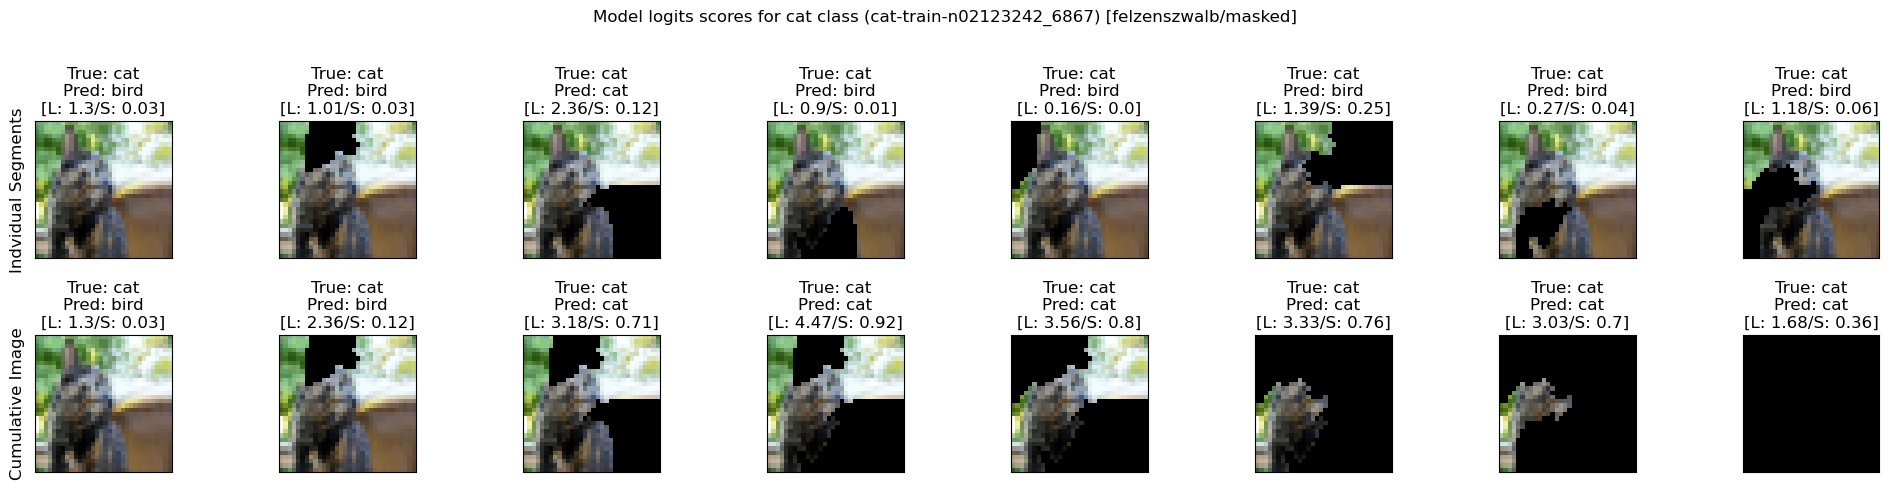

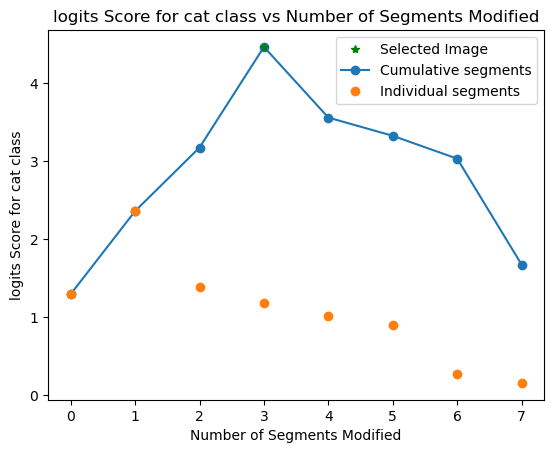

tensor([2, 3, 2, 2, 2, 2, 2, 2], device='cuda:0')
10
torch.Size([8, 3, 32, 32]) torch.Size([8])
tensor([2, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
10
['bird', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat']
bird tensor([1.0225e-02, 6.8559e-04, 9.1304e-01, 3.2533e-02, 6.2060e-03, 9.3146e-03,
        1.8683e-02, 5.4175e-03, 3.0700e-03, 8.2951e-04], device='cuda:0')
cat tensor([0.0392, 0.0104, 0.1061, 0.2535, 0.1435, 0.0435, 0.1812, 0.1571, 0.0089,
        0.0565], device='cuda:0')
cat tensor([0.0275, 0.0018, 0.0962, 0.7058, 0.0218, 0.0266, 0.0662, 0.0249, 0.0068,
        0.0225], device='cuda:0')
cat tensor([1.6392e-02, 3.5385e-04, 1.7367e-02, 9.1698e-01, 5.6518e-03, 1.2597e-02,
        9.5269e-03, 7.0391e-03, 3.6959e-03, 1.0401e-02], device='cuda:0')
cat tensor([9.8311e-02, 5.8373e-04, 1.0041e-02, 8.4748e-01, 5.3472e-03, 6.6098e-03,
        5.4608e-03, 6.8710e-03, 5.7759e-03, 1.3521e-02], device='cuda:0')
cat tensor([0.1225, 0.0019, 0.0159, 0.7435, 0.0121, 0.0125, 0.0090, 0.0383, 0.0060

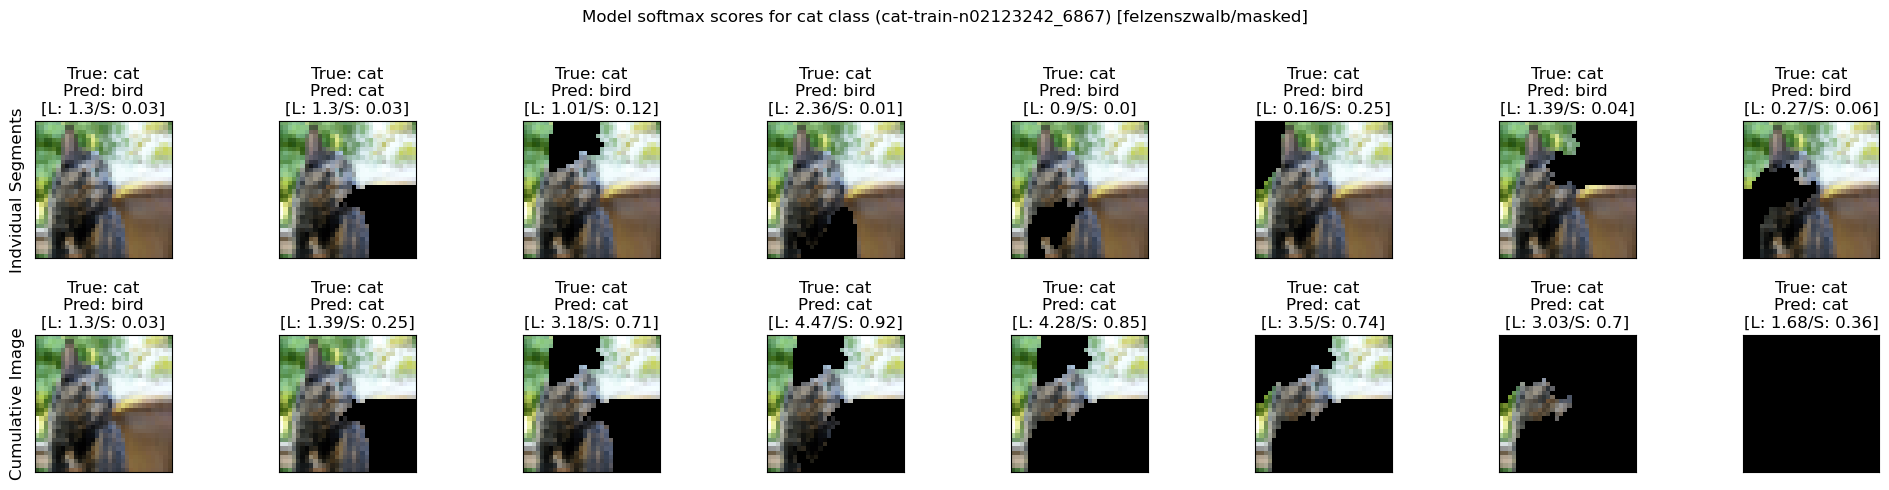

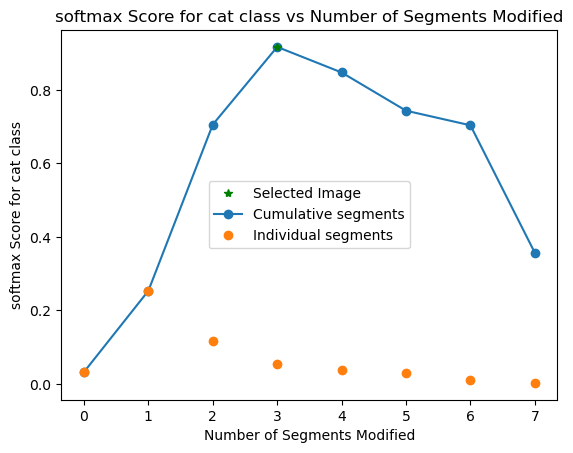

tensor([2, 2, 6, 2, 2, 2, 2, 2], device='cuda:0')
10
torch.Size([8, 3, 32, 32]) torch.Size([8])
tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
10
['bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird']
bird tensor([ 0.1393, -2.5630,  4.6312,  1.2967, -0.3600,  0.0460,  0.7421, -0.4959,
        -1.0639, -2.3725], device='cuda:0')
bird tensor([-0.0516, -2.6822,  3.9513,  1.8386, -0.3405,  0.2090,  0.9151, -0.7016,
        -1.0174, -2.1206], device='cuda:0')
bird tensor([-0.6943, -1.7905,  3.3610,  1.1176, -0.2330, -0.4103,  3.1318, -1.4126,
        -1.3454, -1.7242], device='cuda:0')
bird tensor([-0.6661, -1.7054,  3.5555,  0.8951, -0.2129, -0.4952,  3.2285, -1.4325,
        -1.3509, -1.8160], device='cuda:0')
bird tensor([-0.6452, -1.3432,  4.0922,  0.1116, -0.1568, -0.6134,  3.2796, -1.3529,
        -1.2971, -2.0747], device='cuda:0')
bird tensor([-0.7955, -1.1932,  3.8254,  0.0879, -0.1393, -0.6707,  3.6600, -1.4919,
        -1.3402, -1.9426], device='cuda:0')
bird tensor(

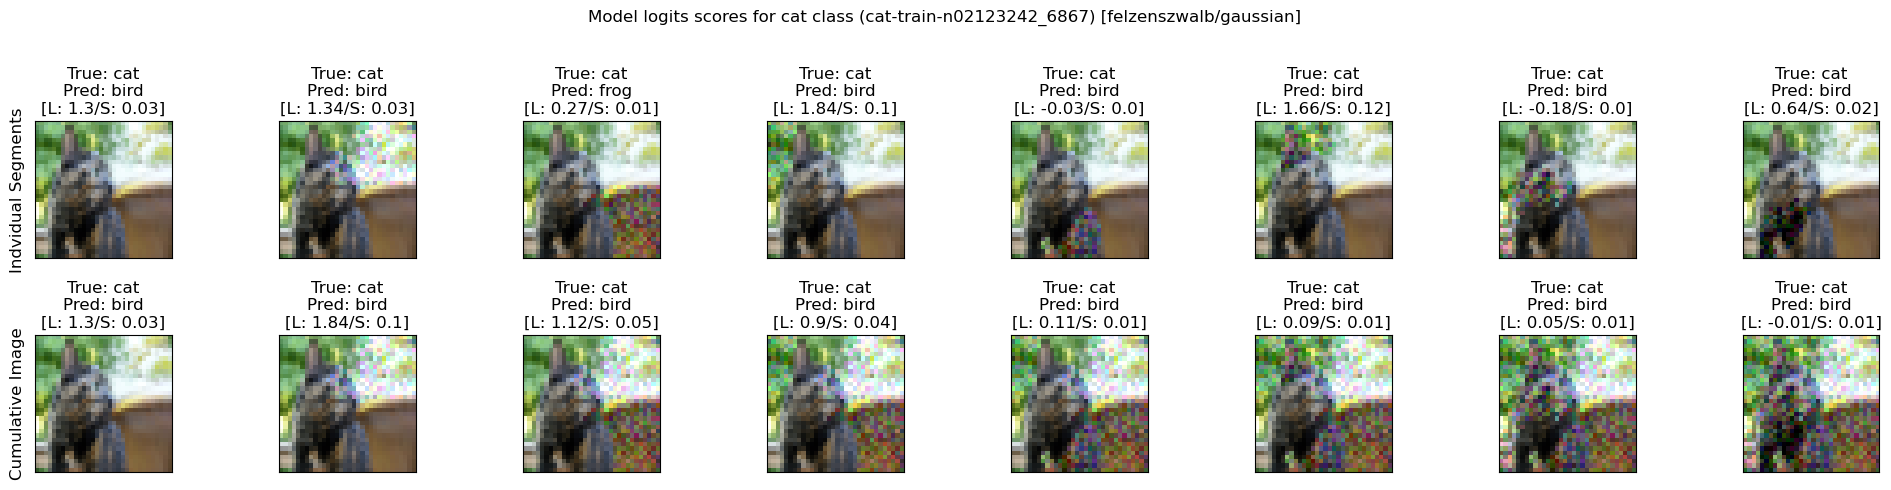

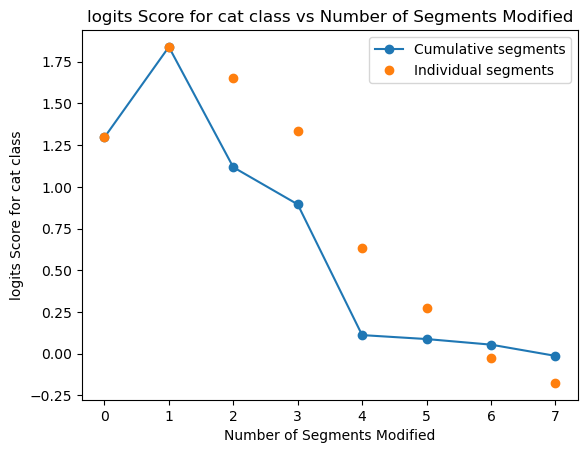

tensor([2, 6, 2, 2, 2, 2, 2, 2], device='cuda:0')
10
torch.Size([8, 3, 32, 32]) torch.Size([8])
tensor([2, 6, 2, 2, 2, 2, 2, 2], device='cuda:0')
10
['bird', 'frog', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird']
bird tensor([1.0225e-02, 6.8559e-04, 9.1304e-01, 3.2533e-02, 6.2060e-03, 9.3146e-03,
        1.8683e-02, 5.4175e-03, 3.0700e-03, 8.2951e-04], device='cuda:0')
frog tensor([0.0115, 0.0029, 0.4019, 0.1170, 0.0171, 0.0156, 0.4171, 0.0056, 0.0059,
        0.0053], device='cuda:0')
bird tensor([0.0087, 0.0029, 0.5004, 0.0531, 0.0138, 0.0115, 0.3979, 0.0042, 0.0045,
        0.0031], device='cuda:0')
bird tensor([0.0078, 0.0028, 0.5347, 0.0374, 0.0123, 0.0093, 0.3856, 0.0036, 0.0040,
        0.0025], device='cuda:0')
bird tensor([0.0058, 0.0029, 0.6624, 0.0124, 0.0095, 0.0060, 0.2939, 0.0029, 0.0030,
        0.0014], device='cuda:0')
bird tensor([0.0051, 0.0034, 0.5177, 0.0123, 0.0098, 0.0058, 0.4387, 0.0025, 0.0030,
        0.0016], device='cuda:0')
bird tensor([0.0062, 0.0034, 0.6

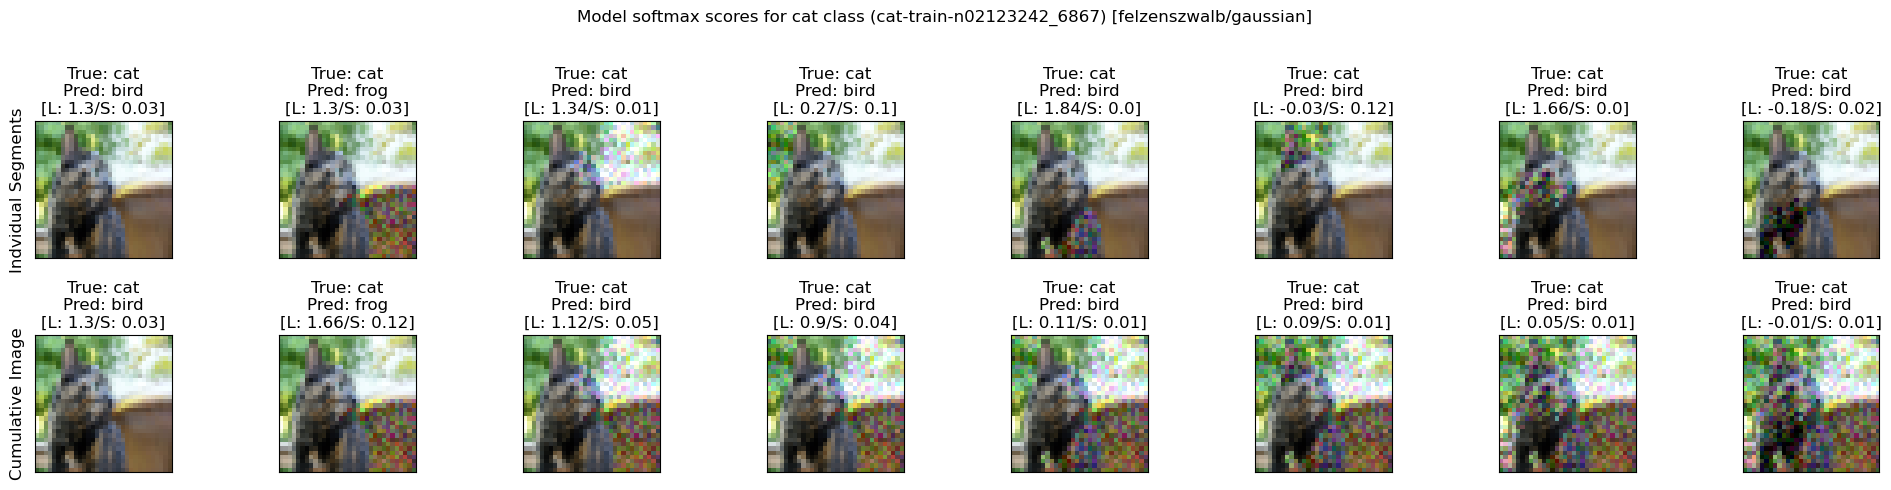

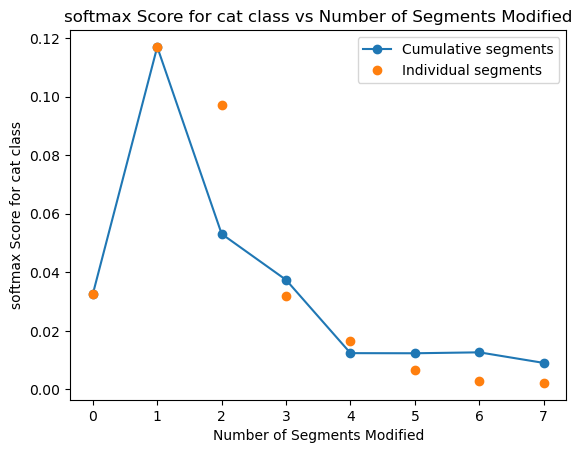

tensor([2, 3, 2, 2, 2, 2], device='cuda:0')
10
torch.Size([6, 3, 32, 32]) torch.Size([6])
tensor([2, 3, 3, 3, 0, 3], device='cuda:0')
10
['bird', 'cat', 'cat', 'cat', 'airplane', 'cat']
bird tensor([ 0.1393, -2.5630,  4.6312,  1.2967, -0.3600,  0.0460,  0.7421, -0.4959,
        -1.0639, -2.3725], device='cuda:0')
cat tensor([ 0.2569, -2.5339,  2.0935,  2.6421, -0.5199,  0.1894,  0.4086, -0.5408,
        -0.9132, -1.0827], device='cuda:0')
cat tensor([ 0.1526, -3.0852,  0.4299,  3.8305, -0.1193,  0.5579, -0.3704,  0.3191,
        -1.3733, -0.3418], device='cuda:0')
cat tensor([ 1.3233, -2.5360,  0.0590,  3.1529, -0.2776, -0.6134, -0.3800, -0.2570,
        -0.6872,  0.2160], device='cuda:0')
airplane tensor([ 0.8583, -0.8634, -0.0647,  0.5509,  0.5756, -0.9571,  0.5757, -0.4704,
        -0.1648, -0.0401], device='cuda:0')
cat tensor([ 0.9380, -1.3702,  0.0521,  1.6757, -0.0875, -0.1917, -0.3167, -1.2568,
         0.8022, -0.2450], device='cuda:0')
out argmax shape torch.Size([])
torch.Si

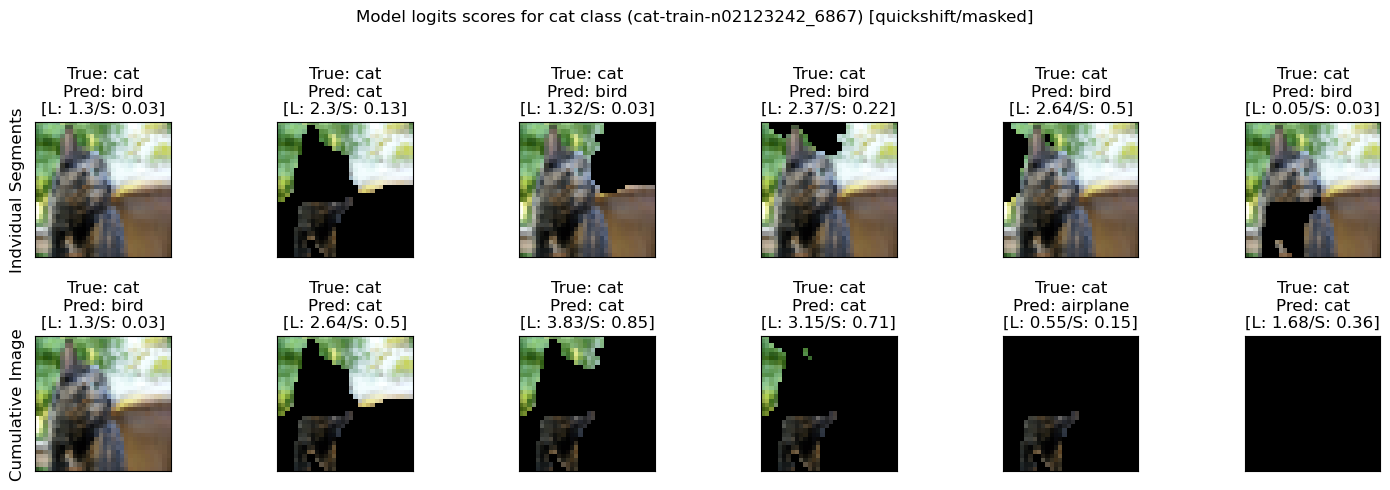

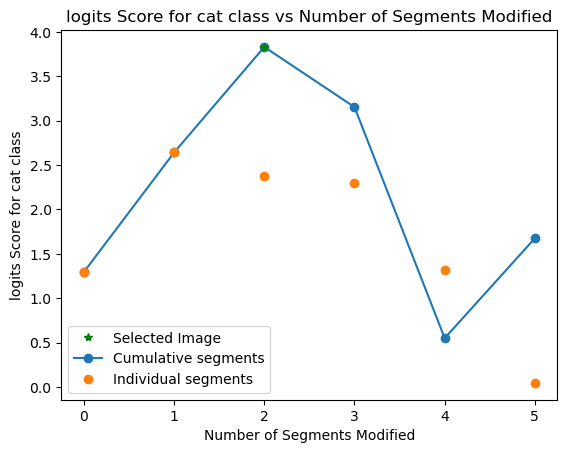

In [ ]:
image_path = key_images[0]
print(image_path)
image = load_image(image_path, data_format='CHW')
image_id = get_image_id(image_path)
class_idx = class_to_idx_dict[target_class]
image_save_dir = os.path.join(save_dir_root, image_id)

informal_log("Target idx: {}".format(class_idx), log_path)
informal_log('Image save directory: {}'.format(image_save_dir), log_path)

segment_semantically(
        image=image,
        image_id=image_id,
        methods_params=methods,
        model=model,
        device=device,
        target_idx=class_idx,
        seed=seed,
        save_dir=image_save_dir,
        debug=debug)
print("done")

In [ ]:
class_idx = class_to_idx_dict[target_class]
key_paths_logits = []
key_paths_softmax = []
key_paths_failures = []
value_paths_logits = []
value_paths_softmax = []
value_paths_failures = []

for idx, image_path in enumerate(key_images):
    informal_log("[{}] Trial {}/{} with image {}...".format(
        datetime.now().strftime(r'%m%d_%H%M%S'),
        idx+1,
        len(key_images),
        image_path), log_path)
    
    # Load image, get ID, create save directory
    image = load_image(image_path, data_format='CHW')
    image_id = get_image_id(image_path)
    image_save_dir = os.path.join(save_dir_root, image_id)
    
    # Run semantic segmentation-modification method
    logit_save_image_paths, \
        softmax_save_image_paths, \
        unsucessful_edit_save_paths = segment_semantically(
            image=image,
            image_id=image_id,
            methods_params=methods,
            model=model,
            device=device,
            target_idx=class_idx,
            seed=seed,
            save_dir=image_save_dir,
            debug=debug)
    
    informal_log("[{}] Saved results to {}".format(datetime.now().strftime(r'%m%d_%H%M%S'), image_save_dir), 
         log_path)
    
    # Create correct number of key paths
    key_paths_l = [image_path for i in range(len(logit_save_image_paths))]
    key_paths_s = [image_path for i in range(len(softmax_save_image_paths))]
    key_paths_f = [image_path for i in range(len(unsucessful_edit_save_paths))]
    
    # Append to key paths lists
    key_paths_logits += key_paths_l
    key_paths_softmax += key_paths_s
    key_paths_failures += key_paths_f
    
    # Append to value paths lists
    value_paths_logits += logit_save_image_paths
    value_paths_softmax += softmax_save_image_paths
    value_paths_failures += unsucessful_edit_save_paths
    

In [123]:
# Save paths
write_lists(os.path.join(path_save_dir, 'key_images_logits.txt'), key_paths_logits)
write_lists(os.path.join(path_save_dir, 'key_images_softmax.txt'), key_paths_softmax)
write_lists(os.path.join(path_save_dir, 'key_images_failures.txt'), key_paths_failures)

write_lists(os.path.join(path_save_dir, 'value_images_logits.txt'), value_paths_logits)
write_lists(os.path.join(path_save_dir, 'value_images_softmax.txt'), value_paths_softmax)
write_lists(os.path.join(path_save_dir, 'value_images_failures.txt'), value_paths_failures)

print("Wrote paths to {}".format(path_save_dir))
            

Wrote paths to paths/edits/semantics/cat/0120_144821


# FIN


## Load and visualize a group of edit image pairs

<class 'list'>
[('data/cinic-10-imagenet/train/cat/n02123394_4630.png', 'saved/segmentations/semantics/cat_20/cat-train-n02123394_4630/quickshift_masked/quickshift_masked_logits.png'), ('data/cinic-10-imagenet/train/cat/n02121808_843.png', 'saved/segmentations/semantics/cat_20/cat-train-n02121808_843/slic_masked/slic_masked_logits.png')]


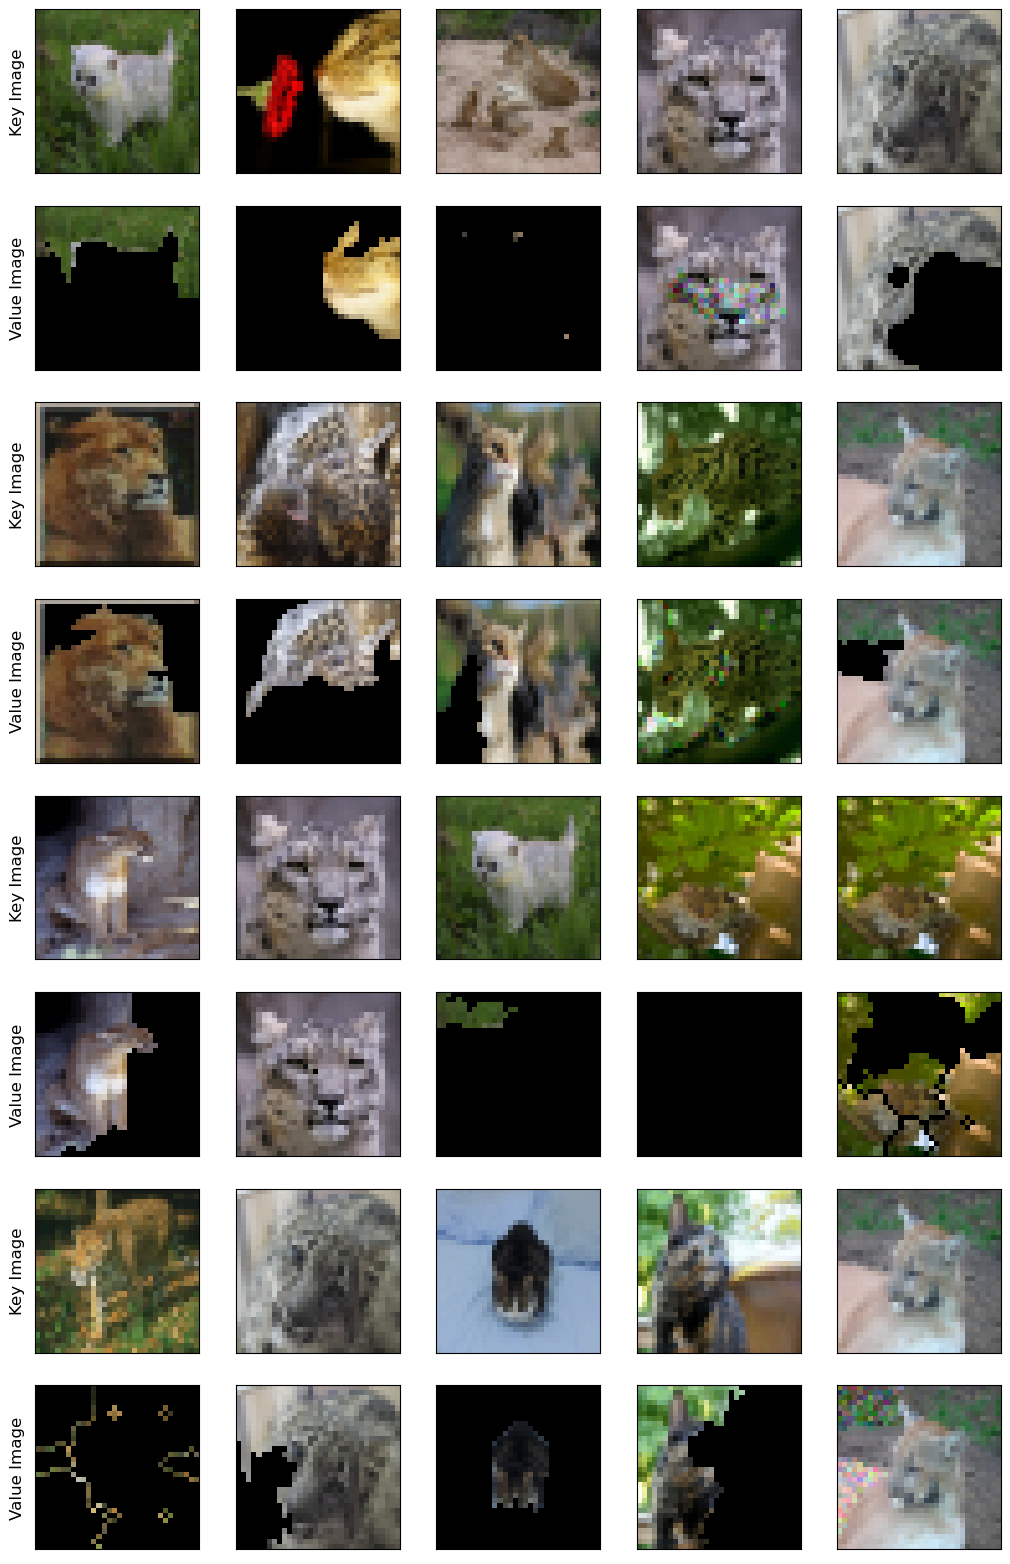

In [27]:
target_class = 'cat'
timestamp = '0120_144821'
sort_type = 'logits'
n_display = 20
n_per_row = 5
paths_root_dir = os.path.join('paths', 'edits', 'semantics', target_class, timestamp)
random.seed(seed)

key_image_paths_path = os.path.join(paths_root_dir, 'key_images_{}.txt'.format(sort_type))
value_image_paths_path = os.path.join(paths_root_dir, 'value_images_{}.txt'.format(sort_type))

key_image_paths = read_lists(key_image_paths_path)
value_image_paths = read_lists(value_image_paths_path)

zipped_paths = list(zip(key_image_paths, value_image_paths))
print(type(zipped_paths))
random.shuffle(zipped_paths)
print(zipped_paths[:2])

key_images = []
value_images = []
for idx, (key_image_path, value_image_path) in enumerate(zipped_paths): #enumerate(zip(key_image_paths, value_image_paths)):
    if idx == n_display:
        break
    key_image = load_image(key_image_path, data_format='HWC')
    value_image = load_image(value_image_path, data_format='HWC')
    
    key_images.append(key_image)
    value_images.append(value_image)
    
# Make both into grid
key_images = make_grid(flattened=key_images, items_per_row=n_per_row)
value_images = make_grid(flattened=value_images, items_per_row=n_per_row)
n_rows = len(key_images)

assert len(value_images) == n_rows
# Intersperse them
master_grid = []
labels = []
for row_idx in range(n_rows):
    master_grid.append(key_images[row_idx])
    labels.append('Key Image')
    master_grid.append(value_images[row_idx])
    labels.append('Value Image')
    
show_image_rows(
    images=master_grid,
    row_labels=labels,
    save_path=os.path.join('temp', "key_val_side_by_side.png"))
    

In [22]:
print(value_image_paths[0])
save_dir = 

SyntaxError: invalid syntax (3623869496.py, line 2)